# Multivariate time series forecasting reference with Apache MXNet and Gluon 


This notebook draws heavy inspiration from [link](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/) and tries to recreate the results with `Apache MXNet` and `Gluon`. The aim of this notebook is to show how multivariate timeseries modeling can be done with Apache MXNet and Gluon. Don't forget to review the very handy `reusable` Gluon Regression class.

## Problem Description
We are forecasting the air pollution with data recorded at the US embassy in Beijing, China for five years.


<p style="font-weight:bold">Dataset Attribution:</p> “PM2.5 data of US Embassy in Beijing”
(https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data)

<p style="font-weight:bold">Dataset Description:</p>
``
No: row number
year: year of data in this row 
month: month of data in this row 
day: day of data in this row 
hour: hour of data in this row 
pm2.5: PM2.5 concentration (ug/m^3) 
DEWP: Dew Point (â„ƒ) 
TEMP: Temperature (â„ƒ) 
PRES: Pressure (hPa) 
cbwd: Combined wind direction 
Iws: Cumulated wind speed (m/s) 
Is: Cumulated hours of snow 
Ir: Cumulated hours of rain
``

### Set-up: Import Required Notebook Libraries
<p>This Notebook requires a few basic Python libraries including <a href="http://pandas.pydata.org/">`pandas`</a>, <a href="http://www.numpy.org/">`numpy`</a>, <a href="https://mxnet.incubator.apache.org/">`mxnet`</a>, <a href="https://docs.python.org/2/library/datetime.html">`datetime`</a>, <a href="scikit-learn.org"> `scikit-learn` </a> and <a href="https://matplotlib.org/">`matplotlib`</a>.</p>

# Load Dataset and clean it up

In [ ]:
import pandas as pd
from datetime import datetime

def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

org_col_names=["No", "year","month", "day", "hour", "pm2.5", "DEWP","TEMP", "PRES", "cbwd", "Iws", "Is", "Ir"]
col_names = ['pollution', 'dew', 'temp', 'pressure', 'w_dir', 'w_speed', 'snow', 'rain']         
dataset = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv',  
                    index_col=0,
                    date_parser=parse,
                    parse_dates=[['year', 'month', 'day', 'hour']])

# Data cleansing
dataset.drop('No', axis=1, inplace=True)
dataset.columns = col_names
dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:] # drop the first day
print(dataset.head(5))
dataset.to_csv('pollution.csv') # save new CSV

```
No: row number
year: year of data in this row
month: month of data in this row
day: day of data in this row
hour: hour of data in this row
pm2.5: PM2.5 concentration
DEWP: Dew Point
TEMP: Temperature
PRES: Pressure
cbwd: Combined wind direction
Iws: Cumulated wind speed
Is: Cumulated hours of snow
Ir: Cumulated hours of rain
```

In [8]:
#Lets load the processed dataset
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


# load dataset
df = read_csv('pollution.csv', header=0, index_col=0)
df.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [9]:
dataset_columns = df.columns.tolist()
dataset_columns

['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  app.launch_new_instance()


{'boxes': [<matplotlib.lines.Line2D at 0x10f15b850>,
 'caps': [<matplotlib.lines.Line2D at 0x10f16a750>,
 'fliers': [<matplotlib.lines.Line2D at 0x10e677a50>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x10e677410>,
 'whiskers': [<matplotlib.lines.Line2D at 0x10f15ba10>,
  <matplotlib.lines.Line2D at 0x10f42f790>]}

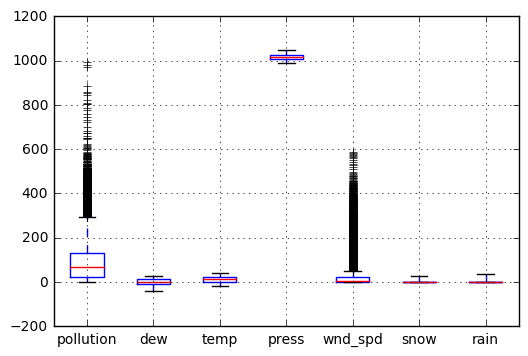

In [10]:
#Box plot
pd.options.display.mpl_style = False
df.boxplot()

From the data looks like the wind speed has the largest standard deviation along with pollution. Lets see how these parameters interact with each other by plotting a correlation matrix.

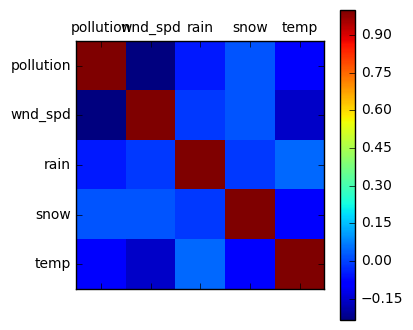

In [14]:
cor_cols = ['pollution', 'wnd_spd', 'rain', 'snow', 'temp']

plt.matshow(df.loc[:, cor_cols].corr())
plt.xticks(range(len(cor_cols)), cor_cols)
plt.yticks(range(len(cor_cols)), cor_cols)
plt.colorbar()
plt.show()

There isn't much here, windspeed is weak (0.2) negatively correlated with pollution which makes sense as wind can cause pollution particles to disperse. None of the other params are correlated in a meaningful manner. This makes the problem more challenging for any statistical based approach. Hence lets use deep learning to forecast pollution count given these variables like temperature, wind speed, rain, snow etc.

Also to dive deeper lets take a look at pairwise scatter matrix for more insights.

### Data Processing

In [17]:
from sklearn.preprocessing import LabelEncoder

# Encode non categorical values
values = df.values
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
values[:,4]

array([ 2.,  2.,  2., ...,  1.,  1.,  1.], dtype=float32)

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

In [19]:
# Generate the sequences
df = pd.DataFrame(scaled_dataset)
cols = []
col_names = []

n_in = 1
n_out = 1
    
n_vars = scaled_dataset.shape[1] # number of variables; here we have 8 variables
print n_vars, scaled_dataset.shape

# input sequence (t-n, ... t-1)
for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    col_names += [('%s(t-%d)' % (dataset_columns[j], i)) for j in range(n_vars)]

# Lets forcecast pollution values
# forecast sequence (t, t+1, ... t+n)
cols.append(df.shift(0))
col_names += [('%s(t)' % dataset_columns[j]) for j in range(n_vars)]
#print col_names, len(col_names)

all_values = pd.concat(cols, axis=1)
all_values.columns = col_names
all_values.dropna(inplace=True) #drop NaN
    
# Only forecasting one variable(pollution) next day, so drop the rest
all_values.drop(all_values.columns[range(9,16)], axis=1, inplace=True)
print(all_values.head())

8 (43800, 8)
   pollution(t-1)  dew(t-1)  temp(t-1)  press(t-1)  wnd_dir(t-1)  \
1        0.129779  0.352941   0.245902    0.527273      0.666667   
2        0.148893  0.367647   0.245902    0.527273      0.666667   
3        0.159960  0.426471   0.229508    0.545454      0.666667   
4        0.182093  0.485294   0.229508    0.563637      0.666667   
5        0.138833  0.485294   0.229508    0.563637      0.666667   

   wnd_spd(t-1)  snow(t-1)  rain(t-1)  pollution(t)  
1      0.002290   0.000000        0.0      0.148893  
2      0.003811   0.000000        0.0      0.159960  
3      0.005332   0.000000        0.0      0.182093  
4      0.008391   0.037037        0.0      0.138833  
5      0.009912   0.074074        0.0      0.109658  


In [21]:
# Next, arrange the data as sequences for training and prediction

seq_len = 1  # sequence length or time step
print "Dataset Shape: ", all_values.values.shape

X = all_values.values[:,:-1] # extract the last column pollution which is our target variable 
y = all_values.values[:,-1] # extract the last column  pollution which is our target variable 

dataX = []; dataY = []
for i in range(0, len(y) - seq_len):
    _x = X[i: i+seq_len]
    _y = y[i: i+seq_len]
    _y = _y[-1] # pick last one as the forecast target
    dataX.append(_x)
    dataY.append(_y)
    
print dataX[0], dataY[0]

Dataset Shape:  (43799, 9)
[[ 0.12977867  0.35294122  0.24590163  0.52727318  0.66666669  0.00229001
   0.          0.        ]] 0.148893


In [23]:
# lets keep the orginal X and y for testing purposes later
n_train_hours = 365 * 24

o_test_X, o_test_y = X[:n_train_hours], y[:n_train_hours]
o_test_X.shape, o_test_y.shape

((8760, 8), (8760,))

In [24]:
# split into train and test sets
n_train_hours = 365 * 24

dataX = np.array(dataX)
dataY = np.array(dataY)

#3D [samples, timesteps, features]
train_X, train_y = dataX[n_train_hours:], dataY[n_train_hours:]
test_X, test_y = dataX[:n_train_hours], dataY[:n_train_hours]

print train_X.shape, train_y.shape, test_X.shape, test_y.shape

(35038, 1, 8) (35038,) (8760, 1, 8) (8760,)


# Keras model

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, nb_epoch=5, 
                    batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# MXNet Symbolic model -- LSTM

In [25]:
import mxnet as mx
batch_size = 72

train_iter = mx.io.NDArrayIter(data=train_X, label=train_y,
                                   data_name="data", label_name="target",
                                   batch_size=batch_size,
                                   shuffle=True)
test_iter = mx.io.NDArrayIter(data=test_X, label=test_y,
                                  data_name="data", label_name="target",
                                  batch_size=batch_size)

In [26]:
import logging
logging.getLogger().setLevel(logging.INFO)

ctx = [mx.cpu(i) for i in range(1)]

# Define the LSTM Neural Network
num_epochs = 25

# Note that when unrolling, if 'merge_outputs' is set to True, 
# the 'outputs' is merged into a single symbol
# In the layout, 'N' represents batch size, 'T' represents sequence length, 
# and 'C' represents the number of dimensions in hidden states.

data = mx.sym.var("data")  # Shape: (N, T, C)
target = mx.sym.var("target")  # Shape: (N, T, C)
data = mx.sym.transpose(data, axes=(1, 0, 2))  # Shape: (T, N, C)

if  isinstance(ctx,list):
    c_ctx = ctx[0]   
else:
    c_ctx = ctx
    
if c_ctx.device_type == 'cpu':
    lstm1 = mx.rnn.LSTMCell(num_hidden=5, prefix="lstm1_")
    lstm2 = mx.rnn.LSTMCell(num_hidden=10, prefix="lstm2_")
else:
    # FusedRNNCell
    lstm1 = mx.rnn.FusedRNNCell(num_hidden=5, mode="lstm", prefix="lstm1_")
    lstm2 = mx.rnn.FusedRNNCell(num_hidden=10, mode="lstm", prefix="lstm2_",
                                    get_next_state=True)

L1, L1_states = lstm1.unroll(length=seq_len, inputs=data, 
                             merge_outputs=True,
                             layout="TNC")  # Shape: (T, N, 5)

L1 = mx.sym.Dropout(L1, p=0.2)  # Shape: (T, N, 5)

L2, L2_states = lstm2.unroll(length=seq_len, inputs=L1, 
                            merge_outputs=True,
                            layout="TNC")  # Shape: (T, N, 10)

L2 = mx.sym.reshape(L2_states[0], shape=(-1, 0), reverse=True)  # Shape: (T * N, 10)
pred = mx.sym.FullyConnected(L2, num_hidden=1, name="pred")
pred = mx.sym.LinearRegressionOutput(data=pred, label=target)

model = mx.mod.Module(symbol=pred, data_names=['data'], 
                    label_names=['target'], context=ctx)

model.fit(train_data=train_iter, eval_data=test_iter,
            initializer=mx.init.Xavier(rnd_type="gaussian", magnitude=1),
            optimizer="adam",
            optimizer_params={"learning_rate": 1E-3},
            batch_end_callback=mx.callback.Speedometer(batch_size, 100),
            eval_metric="mae", num_epoch=num_epochs)

INFO:root:Epoch[0] Batch [100]	Speed: 33522.36 samples/sec	mae=0.068627
INFO:root:Epoch[0] Batch [200]	Speed: 30171.62 samples/sec	mae=0.061740
INFO:root:Epoch[0] Batch [300]	Speed: 46810.34 samples/sec	mae=0.048034
INFO:root:Epoch[0] Batch [400]	Speed: 45065.85 samples/sec	mae=0.035110
INFO:root:Epoch[0] Train-mae=0.027237
INFO:root:Epoch[0] Time cost=0.923
INFO:root:Epoch[0] Validation-mae=0.021806
INFO:root:Epoch[1] Batch [100]	Speed: 45014.87 samples/sec	mae=0.025499
INFO:root:Epoch[1] Batch [200]	Speed: 44778.38 samples/sec	mae=0.023631
INFO:root:Epoch[1] Batch [300]	Speed: 42953.03 samples/sec	mae=0.023732
INFO:root:Epoch[1] Batch [400]	Speed: 44880.80 samples/sec	mae=0.022941
INFO:root:Epoch[1] Train-mae=0.022609
INFO:root:Epoch[1] Time cost=0.805
INFO:root:Epoch[1] Validation-mae=0.017790
INFO:root:Epoch[2] Batch [100]	Speed: 45098.09 samples/sec	mae=0.022231
INFO:root:Epoch[2] Batch [200]	Speed: 44617.42 samples/sec	mae=0.021972
INFO:root:Epoch[2] Batch [300]	Speed: 39491.86 s

### Lets do some predictions

In [27]:
import math
from sklearn.metrics import mean_squared_error

# Prediction
yhat = model.predict(test_iter).asnumpy()
print np.mean((yhat - test_y))

print yhat.shape, test_X.shape, test_X[:, 1:].shape

p_test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
p_test_X.shape

inv_yhat = np.concatenate((yhat, p_test_X[:, 1:]), axis=1)
print inv_yhat.shape

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# scale back
scaled_test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((scaled_test_y, p_test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

-0.000793553
(8760, 1) (8760, 1, 8) (8760, 0, 8)
(8760, 8)
Test RMSE: 33.193


In [28]:
print "actual   ", inv_y[:5]
print "predicted", [round(v,1) for v in inv_yhat[:5]]

actual    [ 148.  159.  181.  138.  109.]
predicted [126.1, 142.0, 153.0, 173.0, 137.6]


# Multi Layer Perceptron baseline

In [266]:
#MLP
num_epochs = 10
data = mx.sym.Variable('data')
target = mx.sym.var("target")
data = mx.sym.Flatten(data=data)
fc1  = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=32)
act1 = mx.sym.Activation(data=fc1, name='relu1', act_type="relu")
fc2  = mx.sym.FullyConnected(data=act1, name='fc2', num_hidden=1)
mlp = mx.sym.LinearRegressionOutput(data=fc2, label=target)

mlp_model = mx.mod.Module(symbol=mlp, data_names=['data'], 
                    label_names=['target'], context=ctx)

mlp_model.fit(train_data=train_iter, eval_data=test_iter,
            initializer=mx.init.Xavier(rnd_type="gaussian", magnitude=1),
            optimizer="adam",
            optimizer_params={"learning_rate": 1E-3},
            batch_end_callback=mx.callback.Speedometer(batch_size, 100),
            eval_metric="mae", num_epoch=num_epochs)

INFO:root:Epoch[0] Batch [100]	Speed: 54128.39 samples/sec	mae=0.099886
INFO:root:Epoch[0] Batch [200]	Speed: 53993.20 samples/sec	mae=0.040477
INFO:root:Epoch[0] Batch [300]	Speed: 68374.86 samples/sec	mae=0.022522
INFO:root:Epoch[0] Batch [400]	Speed: 66013.77 samples/sec	mae=0.017587
INFO:root:Epoch[0] Train-mae=0.017038
INFO:root:Epoch[0] Time cost=0.579
INFO:root:Epoch[0] Validation-mae=0.017052
INFO:root:Epoch[1] Batch [100]	Speed: 47257.47 samples/sec	mae=0.016468
INFO:root:Epoch[1] Batch [200]	Speed: 71434.29 samples/sec	mae=0.015770
INFO:root:Epoch[1] Batch [300]	Speed: 66885.17 samples/sec	mae=0.015061
INFO:root:Epoch[1] Batch [400]	Speed: 69751.84 samples/sec	mae=0.014963
INFO:root:Epoch[1] Train-mae=0.015260
INFO:root:Epoch[1] Time cost=0.591
INFO:root:Epoch[1] Validation-mae=0.015513
INFO:root:Epoch[2] Batch [100]	Speed: 45073.86 samples/sec	mae=0.015185
INFO:root:Epoch[2] Batch [200]	Speed: 62771.36 samples/sec	mae=0.014842
INFO:root:Epoch[2] Batch [300]	Speed: 65685.67 s

In [268]:
# Prediction

yhat = mlp_model.predict(test_iter).asnumpy()
print len(yhat), yhat[0]
print np.mean((yhat - test_y))

print yhat.shape, test_X.shape, test_X[:, 1:].shape

p_test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print p_test_X.shape

inv_yhat = np.concatenate((yhat, p_test_X[:, 1:]), axis=1)
print inv_yhat.shape, type(inv_yhat)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# scale back
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, p_test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

8760 [ 0.13542168]
0.00219827
(8760, 1) (8760, 1, 8) (8760, 0, 8)
(8760, 8)
(8760, 8) <type 'numpy.ndarray'>
Test RMSE: 30.499


MLP for this use case sort of does the trick, We'll need to find the right params for LSTM, I'll leave that as a fun exercise to the reader

In [310]:
# Plot accuracy
import matplotlib.pyplot as plt
import numpy as np
import re

def show_plot(log_tr, log_val):
    idx = np.arange(len(log_tr))

    plt.figure(figsize=(8, 6))
    plt.xlabel("Epoch")
    plt.ylabel("loss")
    plt.plot(idx, log_tr, 'o', linestyle='-', color="r",
             label="Train loss")
    if log_val is not None:
        plt.plot(idx, log_val, 'o', linestyle='-', color="b",
             label="Val loss")
    plt.legend()
    plt.show()    

def plot_mxnet_curves(log_output, metric='accuracy'):
    TR_RE = re.compile('.*?]\sTrain-%s=([\d\.]+)' % metric)
    VA_RE = re.compile('.*?]\sValidation-%s=([\d\.]+)' % metric)
    
    log_tr = [float(x) for x in TR_RE.findall(log_output)]
    log_val = [float(x) for x in VA_RE.findall(log_output)]
    show_plot(log_tr, log_val)

# Gluon Code

In [303]:
import mxnet as mx
import numpy as np
import math

from mxnet import nd, autograd
from sklearn.metrics import mean_squared_error


def get_data(batch, iter_type):
    ''' get data and label from the iterator/dataloader '''
    if iter_type == 'mxiter':
        X_train = batch.data[0].as_in_context(ctx)
        Y_train = batch.label[0].as_in_context(ctx)
    else:
        X_train = batch[0].as_in_context(ctx)
        Y_train = batch[1].as_in_context(ctx)

    return X_train, Y_train
    
class BaseRNNRegressor(mx.gluon.Block):
    def __init__(self, ctx):
        super(BaseRNNRegressor, self).__init__()
        self.ctx = ctx
        self.rnn = None
        self.rnn_size = None
        
    #@override 
    def build_model(self, rnn_type='lstm', rnn_size=128, n_layer=1, n_out=1):
        self.rnn_size = rnn_size
        self.n_layer = n_layer
        self.net = mx.gluon.rnn.LSTM(rnn_size, n_layer, 'NTC')
        self.output = mx.gluon.nn.Dense(n_out)

    #@override 
    def forward(self, inp, hidden):
        rnn_out, hidden = self.net(inp, hidden)
        #simplify
        logits = self.output(rnn_out.reshape((-1, self.rnn_size)))
        return logits, hidden
        
    def detach(self, arrs):
        return [arr.detach() for arr in arrs]

    def compile_model(self, optimizer='adam', lr=1E-3):
        self.collect_params().initialize(mx.init.Xavier(), ctx=self.ctx)
        self.loss = mx.gluon.loss.L1Loss()
        self.optimizer = mx.gluon.Trainer(self.collect_params(), 
                                    optimizer, {'learning_rate': lr})


    def evaluate_accuracy(self, data_iterator, metric='mae', iter_type='mxiter'):
        met = mx.metric.MAE()
        for i, batch in enumerate(data_iterator):
            data, label = get_data(batch, iter_type)
            preds = self.net(data)
            met.update(labels=label, preds=preds)
        return met.get()
    
    def fit(self, train_data, test_data, epochs):
        moving_loss = 0.
        train_loss = []
        val_loss = []
        iter_type = 'numpy'
        
        # Can take MX NDArrayIter, or DataLoader
        if isinstance(train_data, mx.io.NDArrayIter):
            train_iter = train_data
            #total_batches = train_iter.num_data // train_iter.batch_size
            test_iter = test_data
            iter_type = 'mxiter'

        elif isinstance(train_data, list):
            if isinstance(train_data[0], np.ndarray) and isinstance(train_data[1], np.ndarray):
                X, y = train_data[0], train_data[1]
                #print type(test_data[0])
                #if isinstance(test_data[0], np.ndarray):
                #    raise ValueError("need test array to be numpy array")
                tX, ty = test_data[0], test_data[1]
                train_iter = mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset(X, y), 
                                    batch_size=batch_size, shuffle=True, last_batch='discard')
                test_iter = mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset(tX, ty), 
                                    batch_size=batch_size, shuffle=False, last_batch='discard')
                #total_batches = len(X) // batch_size
        else:
            raise "pass mxnet ndarray or numpy array"

        print "data type:", type(train_data), type(test_data), iter_type

        init_state = mx.nd.zeros((1, batch_size, self.rnn_size), ctx)
        hidden = [init_state] * 2
        
        for e in range(epochs):
            if isinstance(train_iter, mx.io.NDArrayIter): train_iter.reset()
            yhat = []
            for i, batch in enumerate(train_iter):
                data, label = get_data(batch, iter_type)
                with autograd.record(train_mode=True):
                    Y_pred, hidden = self.forward(data, hidden)
                    hidden = self.detach(hidden)
                    loss = self.loss(Y_pred, label) 
                    yhat.extend(Y_pred)
                loss.backward()                                        
                self.optimizer.step(batch_size)

                if i == 0:
                    moving_loss = nd.mean(loss).asscalar()
                else:
                    moving_loss = .99 * moving_loss + .01 * mx.nd.mean(loss).asscalar()
            train_loss.append(moving_loss)
            # TODO: add prediction?
            
            test_err = self.evaluate_accuracy(test_iter, iter_type=iter_type)
            val_loss.append(test_err[1])
            print("Epoch %s. Loss: %.10f Test MAE: %s" % (e, moving_loss, test_err))
        return train_loss, val_loss

In [304]:
ctx = mx.cpu()
model = BaseRNNRegressor(ctx)
model.build_model('lstm', rnn_size=seq_len, n_layer=1, n_out=1)
model.compile_model(optimizer='adam')
t_loss, v_loss = model.fit([train_X, train_y], [test_X, test_y], epochs=10)

data type: <type 'list'> <type 'list'> numpy
Epoch 0. Loss: 0.0430312322 Test MAE: ('mae', 0.12320409051610633)
Epoch 1. Loss: 0.0212265480 Test MAE: ('mae', 0.13827456228630142)
Epoch 2. Loss: 0.0149335518 Test MAE: ('mae', 0.14551130130542703)
Epoch 3. Loss: 0.0138093784 Test MAE: ('mae', 0.15244989452870278)
Epoch 4. Loss: 0.0135432033 Test MAE: ('mae', 0.15450714865332579)
Epoch 5. Loss: 0.0135373886 Test MAE: ('mae', 0.15562485157113867)
Epoch 6. Loss: 0.0134379411 Test MAE: ('mae', 0.1552719621995276)
Epoch 7. Loss: 0.0134300791 Test MAE: ('mae', 0.15571429846242996)
Epoch 8. Loss: 0.0132749386 Test MAE: ('mae', 0.15693603227781991)
Epoch 9. Loss: 0.0134212607 Test MAE: ('mae', 0.15684805119192774)


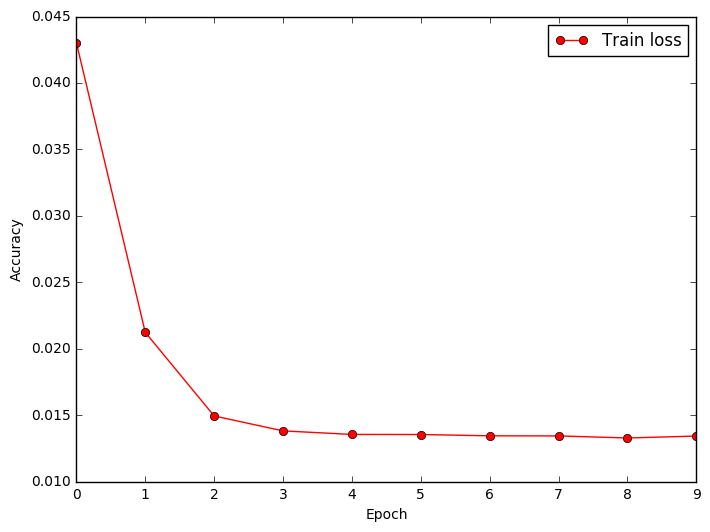

In [309]:
# Show the plot
show_plot(t_loss, None)

In [34]:
# Running Fit function with an iterator
model.fit(train_iter, test_iter, epochs=2)

Epoch 0. Loss: 0.0696829086686, Train_acc 0, Test_acc 0
Epoch 1. Loss: 0.0677475116669, Train_acc 0, Test_acc 0
